# inter-run comparisons of N contained in phytoplankton
    - S3
    - Sentry Shoal
    - Central Node
    - JDF

In [1]:
import pandas as pd
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

In [2]:
plist=['Sentry Shoal','S3','Central node','Central SJDF']

In [3]:
df1=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20140804T234330Z_20150604T070614Z-clean.csv',
        skiprows=78,header=None,
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'))

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df2=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20150604T070624Z_20160307T160206Z-clean.csv',
        skiprows=78,header=None,
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'))

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df=pd.concat([df1.drop(df1[df1.TimeUTC<'2015'].index),df2.drop(df2[df2.TimeUTC>'2016'].index)],ignore_index=True)

In [6]:
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]

In [7]:
df=df.assign(dts=dts)

In [8]:
df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')

In [9]:
df.head()

,TimeUTC,CDOM,CDOMQC,Chlorophyll_ug,ChlQC,Turbidity_NTU,TurbQC,Lat,LatQC,Lon,LongQC,dts
0,2015-01-01T00:00:08.461Z,16.5912,1,1.2463,1,4.5548,1,49.094471,8,-123.426450,8,2015-01-01 00:00:08
1,2015-01-01T00:00:17.515Z,16.948,1,1.2342,1,4.7864,1,49.094835,8,-123.427538,8,2015-01-01 00:00:17
2,2015-01-01T00:00:27.689Z,16.7696,1,1.2221,1,4.632,1,49.095233,8,-123.428714,8,2015-01-01 00:00:27
3,2015-01-01T00:00:37.874Z,16.7696,1,1.3673,1,4.632,1,49.095742,8,-123.429833,8,2015-01-01 00:00:37
4,2015-01-01T00:00:48.048Z,16.948,1,1.2826,1,4.632,1,49.096250,8,-123.430950,8,2015-01-01 00:00:48


In [10]:
df['Lon'][0]

-123.42645043

In [11]:
places.PLACES['S3']

{'GEM2.5 grid ji': (138, 144),
 'NEMO grid ji': (450, 258),
 'lon lat': (-123.558, 49.125)}

In [12]:
111*.0226

2.5086

In [14]:
llon=places.PLACES['S3']['lon lat'][0]-.01
ulon=places.PLACES['S3']['lon lat'][0]+.01
llat=places.PLACES['S3']['lon lat'][1]-.01
ulat=places.PLACES['S3']['lon lat'][1]+.01
iidfnd=(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)

(datetime.datetime(2015, 3, 6, 0, 0), datetime.datetime(2015, 3, 16, 0, 0))

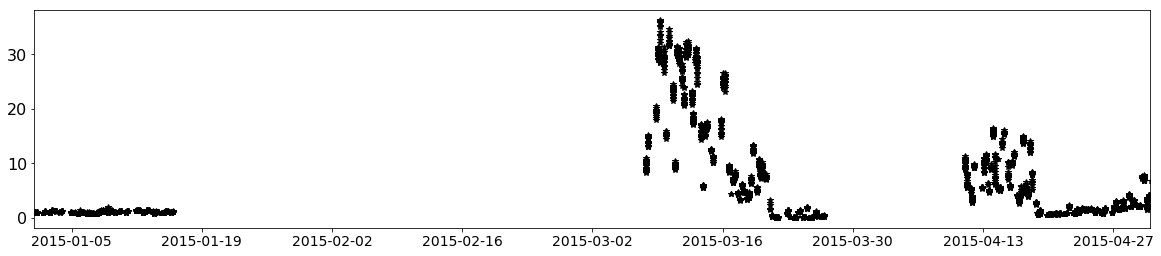

In [15]:
fig,ax=plt.subplots(1,1,figsize=(20,4))
ax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['Chlorophyll_ug']],'k*')
ax.set_xlim(dt.datetime(2015,1,1),dt.datetime(2015,5,1))
dt.datetime(2014,12,31)+dt.timedelta(days=65),dt.datetime(2014,12,31)+dt.timedelta(days=75)

In [16]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

t0=dt.datetime(2015,2,6)
fdur=10 # length of each results file in days
fnum=18 # number of results files per run
runlen=fdur*fnum # length of run in days
#stm=np.shape(tmask)

In [17]:
saveloc='/data/eolson/MEOPAR/SS36runs/calcFiles/comparePhytoN/'
baseloc='/data/eolson/MEOPAR/SS36runs/CedarRuns/'
dirname1='hindcast2015'
dirname2='spring2015_T3'
dirnames=(dirname1,)
#dirnames=('spring2015_NewSink','spring2015_slowPP','spring2015_KhT','spring2015_diatHS')
varNameDict={'Sentry Shoal':'SentryShoal', 'S3':'S3', 'Central node':'CentralNode', 'Central SJDF':'CentralSJDF'}
with open('/ocean/eolson/MEOPAR/analysis-elise/notebooks/bioTuning/spathsMaster.txt') as f:
    spaths = dict(x.strip().split() for x in f)
#spaths={'spring2015_NewSink':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_NewSink/',
#    'spring2015_KhT':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_KhT/',
#    'spring2015_uzoo':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzoo/',
#    'spring2015_uzoo2':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzoo2/',
#    'spring2015_slowPP':'/data/eolson/results/MEOPAR/SS36runs/OrcinusRuns/spring2015_slowPP/',
#    'spring2015_lowMuNano':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_lowMuNano/',
#    'spring2015_SMELTBFastSink':'/data/eolson/results/MEOPAR/SS36runs/OrcinusRuns/spring2015_SMELTBFastSink/',
#    'spring2015_uzPref':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzPref/',
#    'spring2015_hiNH':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_hiNH/'}
ff=dict()
for idir in dirnames:
    ff[idir]=dict()
    for pl in plist:
        print(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
        ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
    #try:
    #    pl='Total'
    #    ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
    #except:
    #    pass

/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_S3.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_CentralNode.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_CentralSJDF.nc


In [18]:
spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc'

'/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_CentralSJDF.nc'

In [19]:
times=dict()
for idir in dirnames:
    f=ff[idir]['S3']
    torig=dt.datetime.strptime(f.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
    print(torig)
    times[idir]=np.array([torig + dt.timedelta(seconds=ii) for ii in f.variables['time_centered'][:]])

1900-01-01 00:00:00


In [20]:
lcol={dirname1:{'diatoms':'darkgreen','flagellates':'mediumblue','ciliates':'maroon'},
     dirname2:{'diatoms':'c','flagellates':'blueviolet','ciliates':'orange'}}
lsty={dirname1:'-',
      dirname2:'--'}

In [21]:
tmins=list()
tmaxs=list()
for idir in dirnames:
    tmins.append(times[idir][0])
    tmaxs.append(times[idir][-1])
xl=(np.min(np.array(tmins)),np.max(np.array(tmaxs)))

In [22]:
sumVarTr={'diatoms':'diatSum','flagellates':'flagSum','ciliates':'myriSum'}

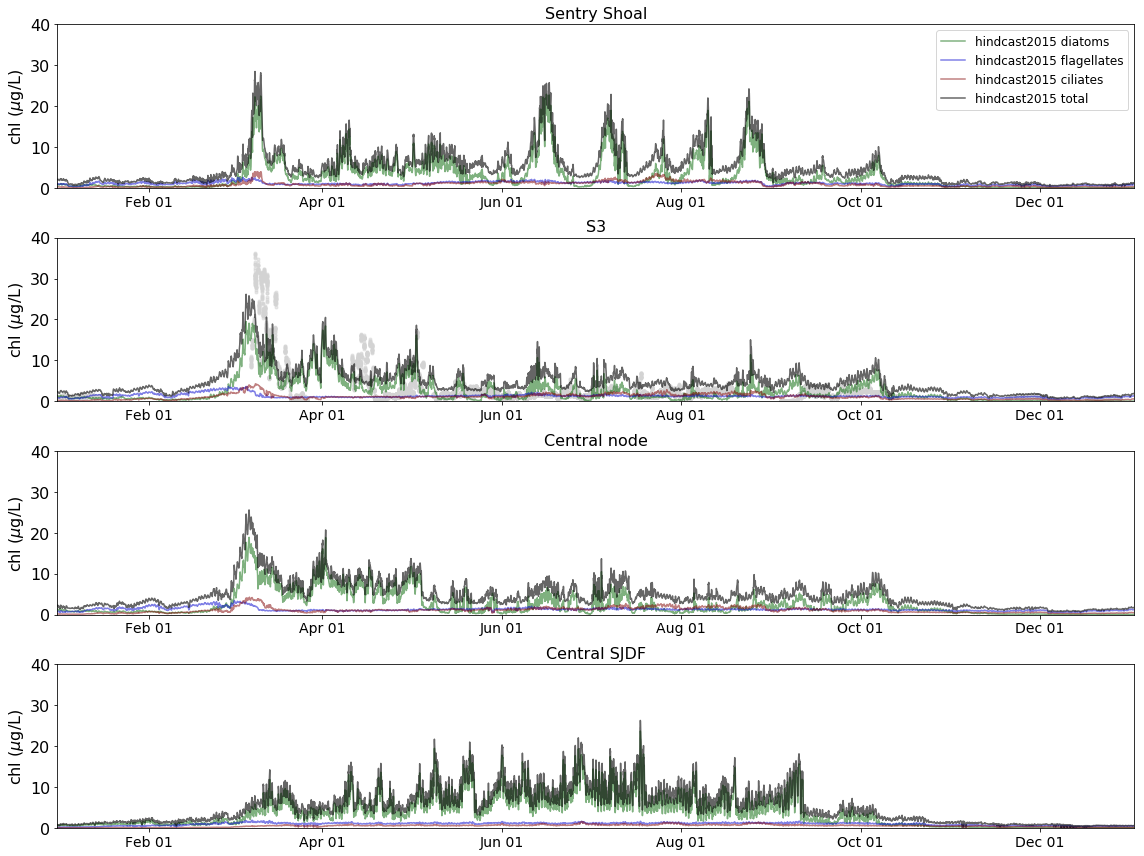

In [23]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(len(plist),1,figsize=(16,3*(len(plist))))
pp=dict()
for ii in range(0,len(plist)):
    pl=plist[ii]
    if pl=='S3':
        ax[ii].plot(df.loc[iidfnd,['dts']],[float(ik[0]) for ik in df.loc[iidfnd,['Chlorophyll_ug']].values],'.',color='lightgray',alpha=.5)
    pp[ii]=dict()
    for idir in dirnames:
        f=ff[idir][pl]
        for var in ('diatoms','flagellates','ciliates'):
            try:
                pp[ii][var]=ax[ii].plot(times[idir],2.0*np.sum(f.variables[var][:,:3,0,0]*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
            except:
                pp[ii][var]=ax[ii].plot(times[idir],2.0*np.sum(f.variables[var][:,:3,0,0]*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
        try:
            pp[ii]['tot']=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
                          linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')
        except:
            pp[ii]['tot']=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
                          linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')
    ax[ii].set_title(pl)
    ax[ii].set_ylabel('chl ($\mu$g/L)')
    ax[ii].xaxis.set_major_formatter(yearsFmt)
    ax[ii].set_xlim(xl)
    ax[ii].set_ylim(0,40)
    if ii==0:
        ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)

plt.tight_layout()

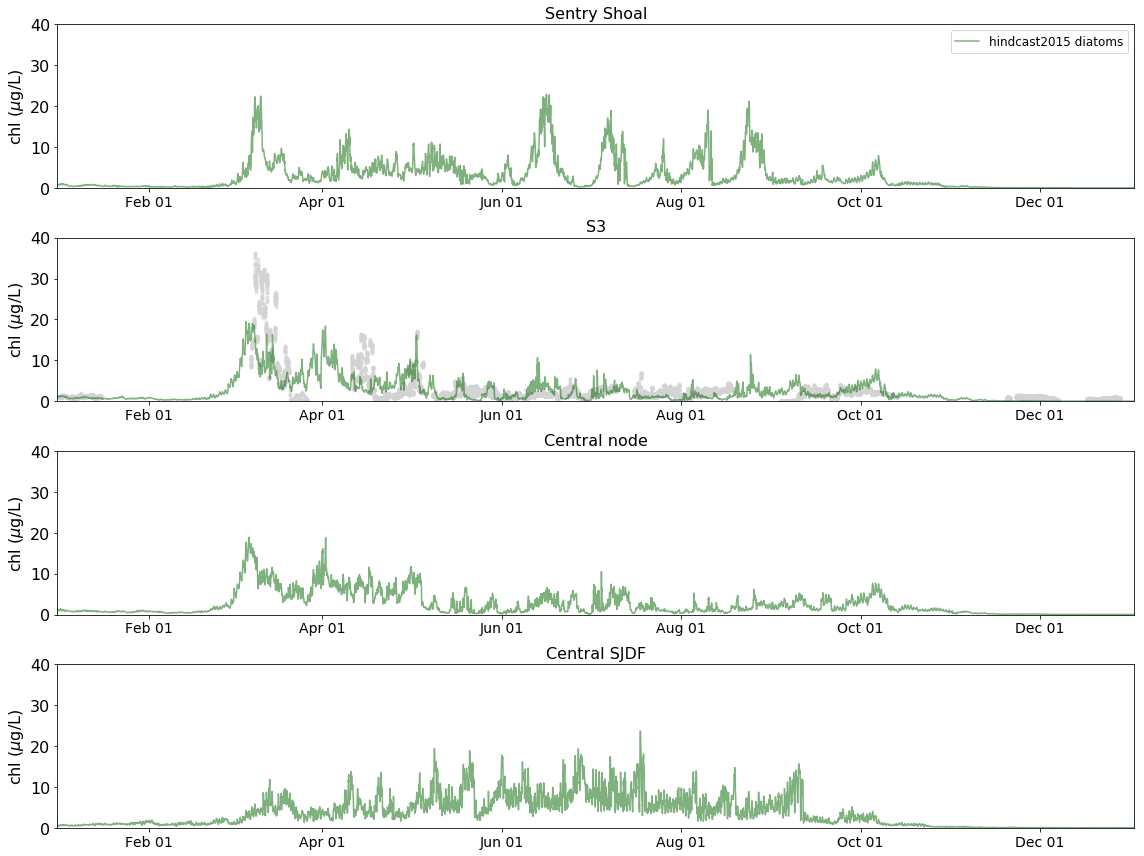

In [24]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(len(plist),1,figsize=(16,3*(len(plist))))
pp=dict()
for ii in range(0,len(plist)):
    pl=plist[ii]
    if pl=='S3':
        ax[ii].plot(df.loc[iidfnd,['dts']],[float(ik[0]) for ik in df.loc[iidfnd,['Chlorophyll_ug']].values],'.',color='lightgray',alpha=.5)
    pp[ii]=dict()
    for idir in dirnames:
        f=ff[idir][pl]
        for var in ('diatoms',):#,'flagellates','ciliates'):
            try:
                pp[ii][var]=ax[ii].plot(times[idir],2.0*np.sum(f.variables[var][:,:3,0,0]*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
            except:
                pp[ii][var]=ax[ii].plot(times[idir],2.0*np.sum(f.variables[var][:,:3,0,0]*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
        #try:
        #    pp[ii]['tot']=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
        #                  linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')
        #except:
        #    pp[ii]['tot']=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
        #                  linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')
    ax[ii].set_title(pl)
    ax[ii].set_ylabel('chl ($\mu$g/L)')
    ax[ii].xaxis.set_major_formatter(yearsFmt)
    ax[ii].set_xlim(xl)
    ax[ii].set_ylim(0,40)
    if ii==0:
        ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)

plt.tight_layout()

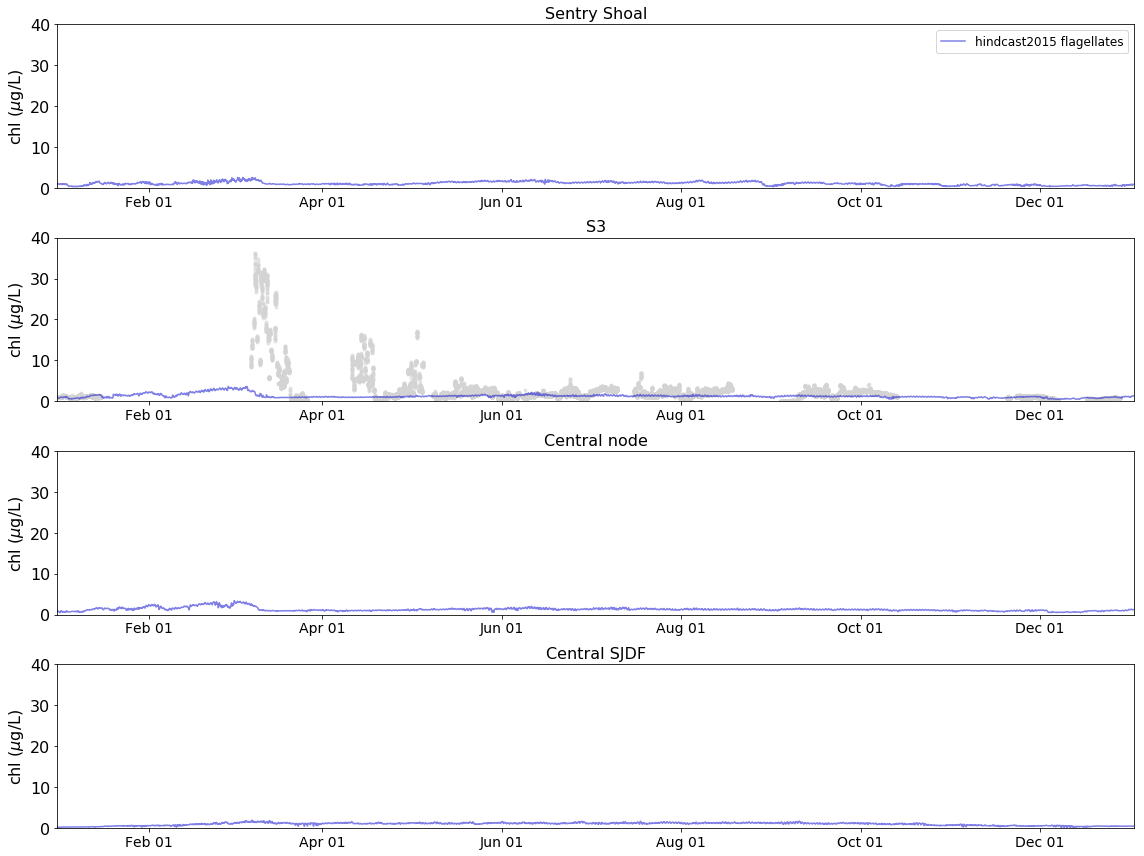

In [25]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(len(plist),1,figsize=(16,3*(len(plist))))
pp=dict()
for ii in range(0,len(plist)):
    pl=plist[ii]
    if pl=='S3':
        ax[ii].plot(df.loc[iidfnd,['dts']],[float(ik[0]) for ik in df.loc[iidfnd,['Chlorophyll_ug']].values],'.',color='lightgray',alpha=.5)
    pp[ii]=dict()
    for idir in dirnames:
        f=ff[idir][pl]
        for var in ('flagellates',):#,'flagellates','ciliates'):
            try:
                pp[ii][var]=ax[ii].plot(times[idir],2.0*np.sum(f.variables[var][:,:3,0,0]*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
            except:
                pp[ii][var]=ax[ii].plot(times[idir],2.0*np.sum(f.variables[var][:,:3,0,0]*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
        #try:
        #    pp[ii]['tot']=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
        #                  linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')
        #except:
        #    pp[ii]['tot']=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
        #                  linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')
    ax[ii].set_title(pl)
    ax[ii].set_ylabel('chl ($\mu$g/L)')
    ax[ii].xaxis.set_major_formatter(yearsFmt)
    ax[ii].set_xlim(xl)
    ax[ii].set_ylim(0,40)
    if ii==0:
        ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)

plt.tight_layout()

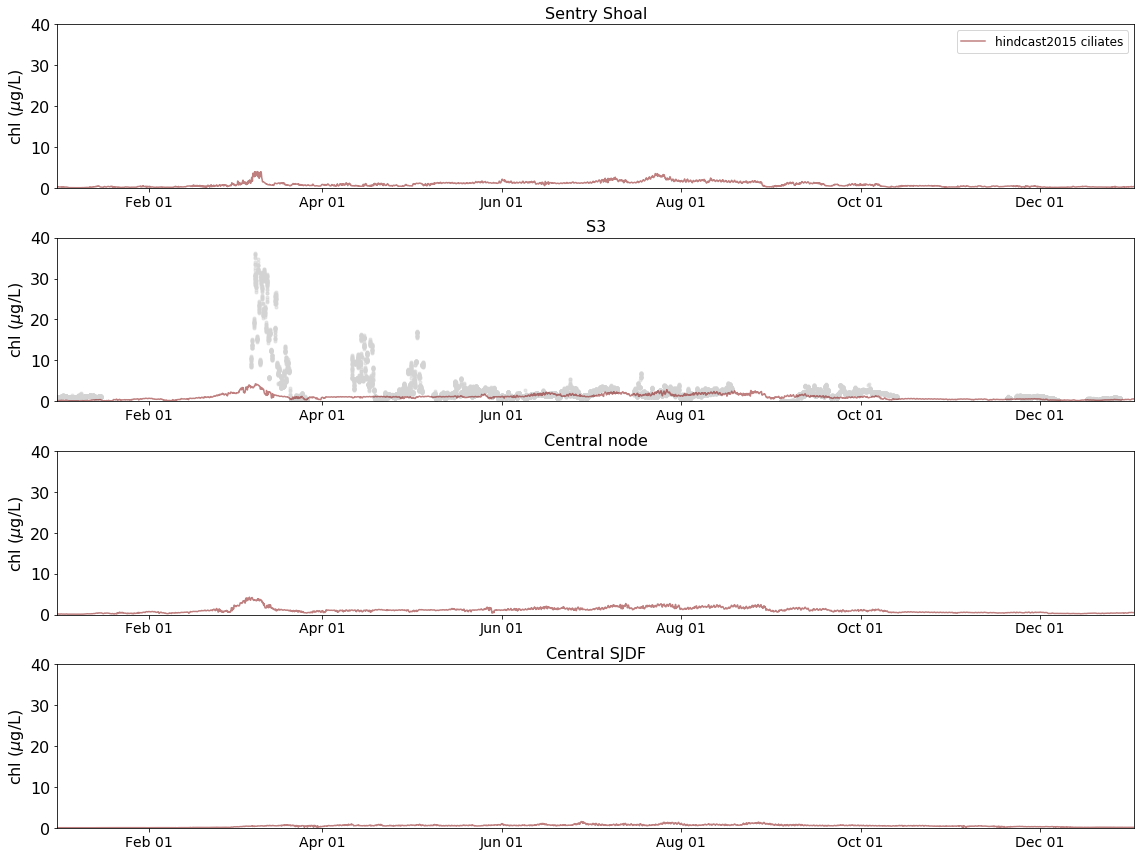

In [26]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(len(plist),1,figsize=(16,3*(len(plist))))
pp=dict()
for ii in range(0,len(plist)):
    pl=plist[ii]
    if pl=='S3':
        ax[ii].plot(df.loc[iidfnd,['dts']],[float(ik[0]) for ik in df.loc[iidfnd,['Chlorophyll_ug']].values],'.',color='lightgray',alpha=.5)
    pp[ii]=dict()
    for idir in dirnames:
        f=ff[idir][pl]
        for var in ('ciliates',):#,'flagellates','ciliates'):
            try:
                pp[ii][var]=ax[ii].plot(times[idir],2.0*np.sum(f.variables[var][:,:3,0,0]*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
            except:
                pp[ii][var]=ax[ii].plot(times[idir],2.0*np.sum(f.variables[var][:,:3,0,0]*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
        #try:
        #    pp[ii]['tot']=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
        #                  linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')
        #except:
        #    pp[ii]['tot']=ax[ii].plot(times[idir],2.0*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
        #                  linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')
    ax[ii].set_title(pl)
    ax[ii].set_ylabel('chl ($\mu$g/L)')
    ax[ii].xaxis.set_major_formatter(yearsFmt)
    ax[ii].set_xlim(xl)
    ax[ii].set_ylim(0,40)
    if ii==0:
        ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)

plt.tight_layout()

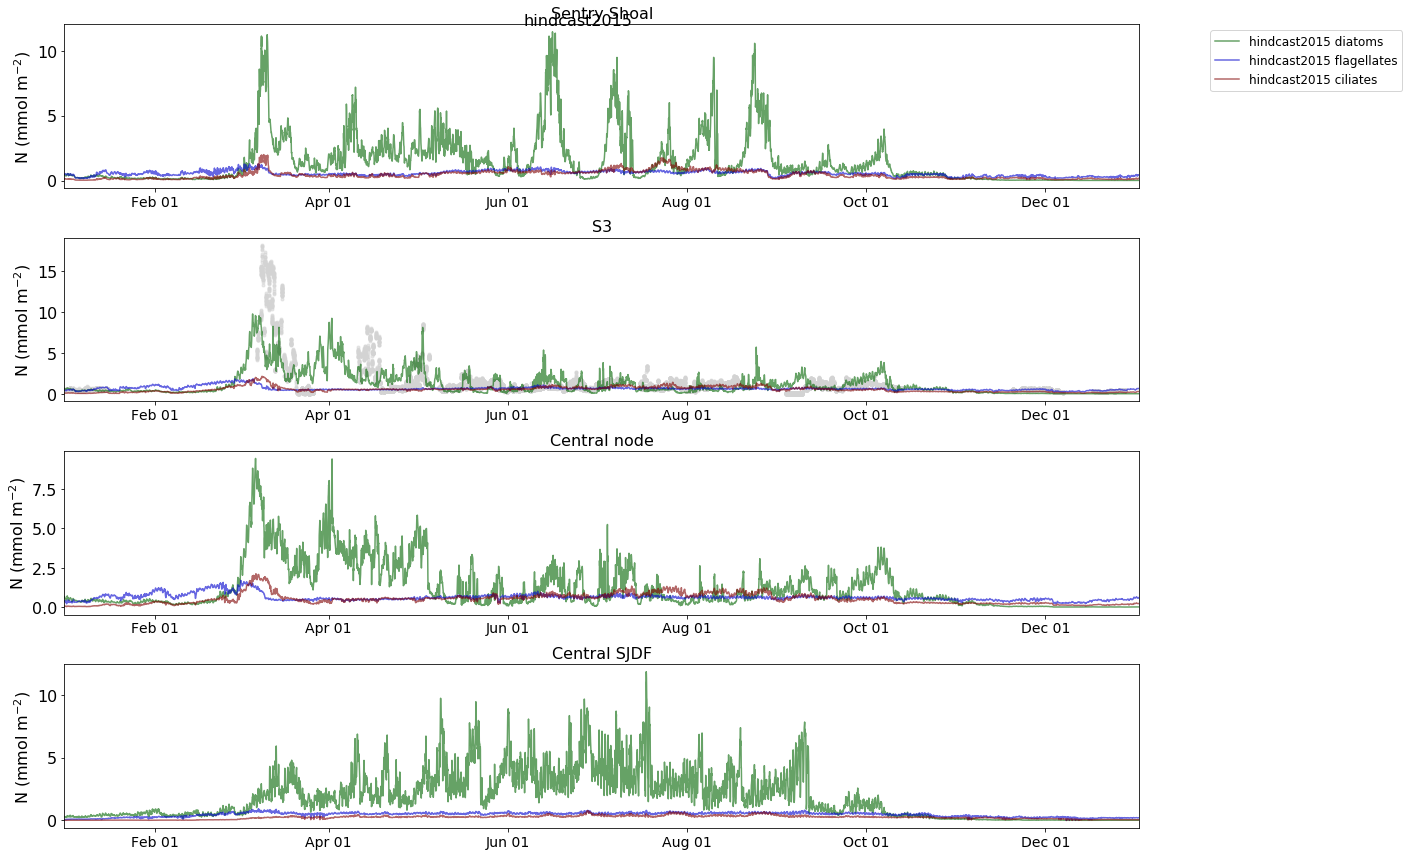

In [27]:
# one at a time
yearsFmt = mdates.DateFormatter('%b %d')
for idir in dirnames:
    fig,ax=plt.subplots(len(plist),1,figsize=(16,3*(len(plist))))
    pp=dict()
    for ii in range(0,len(plist)):
        pl=plist[ii]
        if pl=='S3':
            ax[ii].plot(df.loc[iidfnd,['dts']],[(1/2.0)*float(ik[0]) for ik in df.loc[iidfnd,['Chlorophyll_ug']].values],'.',color='lightgray',alpha=.5)
        pp[ii]=dict()
        f=ff[idir][pl]
        for var in ('diatoms','flagellates','ciliates'):
            try:
                pp[ii][var]=ax[ii].plot(times[idir],np.sum(f.variables[var][:,:3,0,0]*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.6,label=idir+' '+var)
            except:
                pp[ii][var]=ax[ii].plot(times[idir],np.sum(f.variables[var][:,:3,0,0]*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.6,label=idir+' '+var)
        ax[ii].set_title(pl)
        ax[ii].set_ylabel('N (mmol m$^{-2}$)')
        ax[ii].xaxis.set_major_formatter(yearsFmt)
        ax[ii].set_xlim(xl)
        if ii==0:
            ax[0].legend(bbox_to_anchor=(1.25,1),fontsize=12)

    fig.suptitle(idir)
    plt.tight_layout()